# Galaxy Clustering

In this lesson, we will learn how to compute the clustering of galaxies as a probe of large scale structure.

## Distribution of Galaxies is not Random

Let's go back to an old figure from class 2:

/Users/runquanguan/anaconda3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


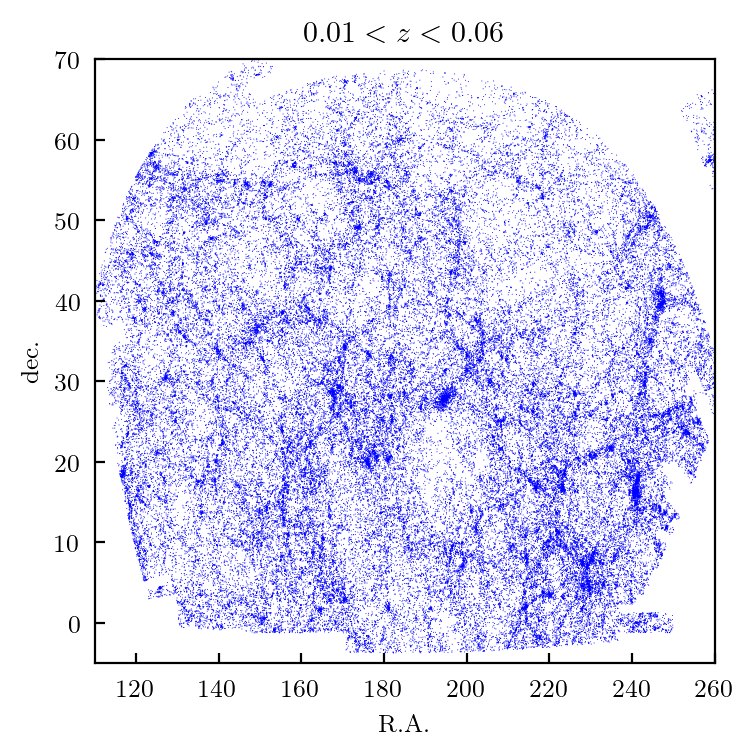

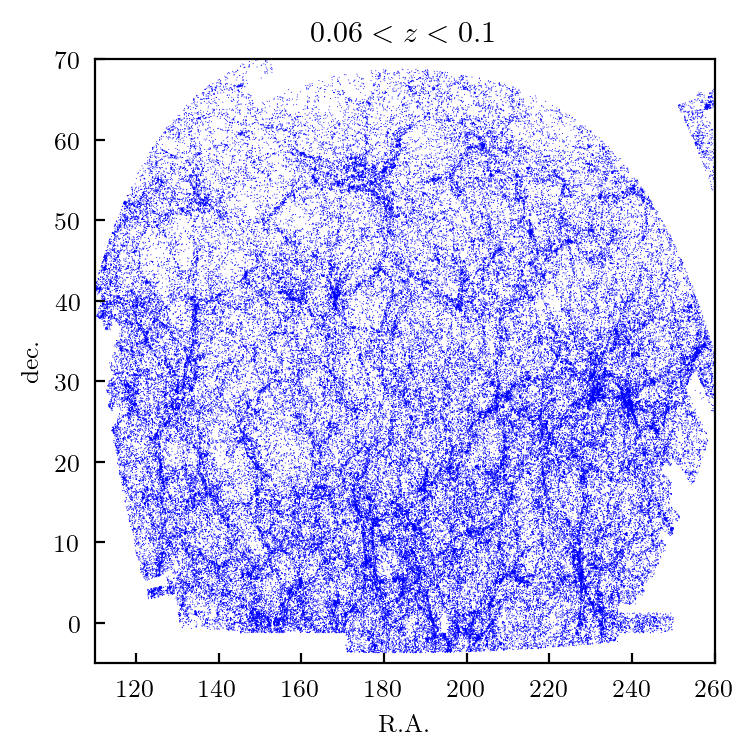

In [1]:
import numpy as np
from classcode.read_sdss_fits import read_sdss_fits
from classcode.setupdir import data_home_dir
%matplotlib inline
import matplotlib.pyplot as plt
from classcode.plot_utils import plot_pretty
plot_pretty(dpi=200)

"""
plot the large scale structure seen in SDSS

"""

# read fits file with the SDSS DR8 main spectroscopic sample
# The SDSS data file should be under your data directory
adata = read_sdss_fits(data_home_dir()+'/SDSSspecgalsDR8full.fits')

# RA and DEC cuts
datac = adata[(adata['dec'] > -10) & (adata['dec'] < 75) & (adata['ra'] > 100) & (adata['ra'] < 270)]
z = datac['z']

datap = datac[(z > 0.01) & (z < 0.06)]

xlabel = r'$\mathrm{R.A.}$'; ylabel = r'$\mathrm{dec.}$'
xlim = [110.,260.]; ylim =[-5.,70]

# Plot the results

fig = plt.figure(figsize=(4, 4))
plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel(r'$\mathrm{R.A.}$')
plt.ylabel(r'$\mathrm{dec.}$')
plt.scatter(datap['ra'],datap['dec'], marker='.', edgecolor='none', color='blue', s=.5, alpha=1.)
plt.title(r'$0.01<z<0.06$')
plt.show()

datap = datac[(z > 0.06) & (z < 0.1)]
fig = plt.figure(figsize=(4, 4))
plt.xlim(xlim); plt.ylim(ylim)
plt.xlabel(r'$\mathrm{R.A.}$')
plt.ylabel(r'$\mathrm{dec.}$')
plt.scatter(datap['ra'],datap['dec'], marker='.', edgecolor='none', color='blue', s=.5, alpha=1.)

plt.title(r'$0.06<z<0.1$')
plt.show()

## Quantifying Galaxy Clustering

**Question** 

(don't cheat by looking below!)

What is the probability of finding a galaxy in a volume element dV at a separation r from another galaxy given the galaxy number density $n$ (also often written as $\overline{n}$, and called "n bar")? 


**The 2-point correlation function**

The 2-point correlation function is one of the most commonly used statistics for quantifying galaxy clustering. 

It is defined as <b>excess probability</b> (relative to a uniform distribution of galaxies) of finding a pair of galaxies separated by distance $r$.

It can be thought of as a lumpiness factor - the higher the value for some distance scale, the more lumpy the universe is at that distance scale. A positive values is an overdensity - and negative values is an underdensity.

Mathematically, the correlation function in 3D space, $\xi(r)$, is defined as:

<br>
$$dP=\bar{n}\left[1+\xi(r)\right]dV,$$
<br>

where $\bar{n}$ is the mean number density (number of galaxies per unit volume) of galaxies in the sample.

Analogy taken from Will Percival's lectures on <a href="https://arxiv.org/abs/1312.5490">Large Scale Structure</a>:

"$\xi(r)$ measures the excess clustering of galaxies at a separation r. Imagine throwing down a large number of randomly placed, equal length r, sticks within a survey. Then the correlation function for that separation r is the excessive fraction of sticks with a galaxy close to both ends, compared with sticks that have randomly chosen points within the survey window close to both ends."

* $\xi(r)>0$ correspond to clustering
* $\xi(r)<0$ correspond to anti-clustering

*Ok, so how do we compute the correlation function in practice?*

<img width=500 align=left src="slidesfigs/your_turn.JPG"></img>

This is a catalog of galaxies from the COSMOS ACS field selected to have magnitude $i<23$:

https://www.dropbox.com/s/b8ks6v72kvwcbhq/cosmos_acs_mag23.txt?dl=0

COSMOS is a 2deg$^2$ field that has the largest contigious imaging by the Hubble Space Telescope. The catalog comes from <a href="http://adsabs.harvard.edu/abs/2007ApJS..172..219L">Leauthaud et al. 2007</a>

Place this catalog in your data directory.

Read in the catalog and plot the RA and DEC of the galaxy sample.

Discuss with your neighbour: 

1) how would you compute the two point correlation function for this sample?

2) what would the two point correlation function look like on large scales? 

3) download this file and display it in ds9
https://www.dropbox.com/s/2phuj2r88nwuzth/COSMOS_borders_F814W_mask.fits?dl=0

4) What artificial effects might come into play when computing the correlation function on small scales? And on large scales?

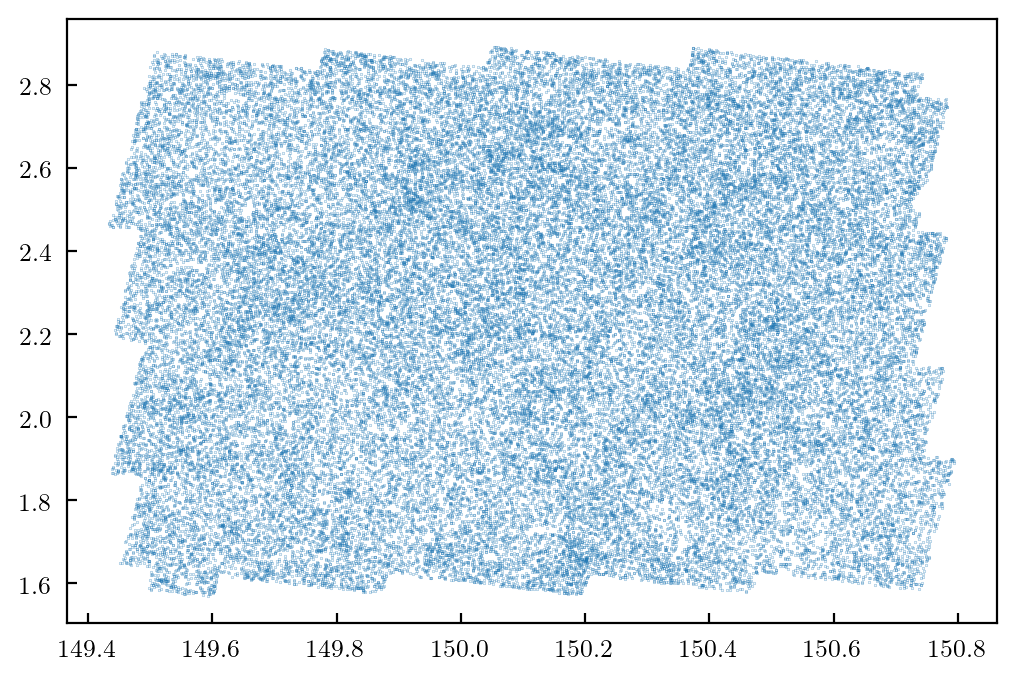

In [11]:
# Your code goes here
# Plot the RA and DEC distribution of the COSMOS galaxy sample

# read fits file with the SDSS DR8 main spectroscopic sample
# The SDSS data file should be under your data directory

plot_pretty(dpi=200)

adata = np.loadtxt(data_home_dir()+'/cosmos_acs_mag23.txt',skiprows = 4)


# RA and DEC cuts
ra = []
dec = []

for i in np.arange(len(adata)):
    ra.append(adata[i][0]),dec.append(adata[i][1])

plt.scatter(ra,dec,s=0.01)

### Estimating the 2pt correlation function in practice


To measure $\xi(r)$, we count pairs of galaxies as a function of separation and divide by the expectation for an unclustered distribution. 

To do this one must construct a **random catalog** that has the identical three dimensional coverage as the data - including the same sky coverage, and any other masks that have been applied (e.g. star masks, image defects), but is populated with randomly-distributed points. 

A popular way to deal with survey masks is using HEALPIX (Hierarchical, Equal Area, and iso- Latitude Pixelisation of the sphere) masks. The <a href="http://healpy.readthedocs.io/en/latest/tutorial.html">Healpy python package</a> can be used to manipuate such masks.

For more information about Healpix read <a href="https://healpix.jpl.nasa.gov/pdf/intro.pdf">The Healpix primer</a>

The Healpix method uses a set of **base-resolution pixels** corresponding to twelve pixels in three rings around the poles and equator.

The resolution of the grid is expressed by the parameter **Nside** which defines the number of divisions along the **side of a base-resolution pixel** that is needed to reach a desired high-resolution partition.


<img width=700 align=left src="slidesfigs/healpix.png"></img>

The ratio of pairs of galaxies observed in the data relative to pairs of points in the random catalog is then used to estimate $\xi(r)$. 

Several different estimators for $\xi(r)$ have been proposed. An early estimator that was widely used is from **Davis & Peebles (1983)** and is the following

The most simple and the most intutitive way to estimate a 2-point correlation function is as follows
<br>
$$
\xi\left(r\right) = \frac{n_R}{n_D}\frac{DD(r)}{RR(r) - 1}
$$
<br>

where $DD(r)$ and $DR(r)$ are counts of pairs of galaxies (in bins of separation) in the data catalog and between the data and random catalogs, and $n_D$ and $n_R$ are the mean number densities of galaxies in the data and random catalogs. This is how correlation functions have been estimated until mid-1990s. 


Another estimators with improved properties have been proposed. The most popular one is the <a href="http://adsabs.harvard.edu/abs/1993ApJ...412...64L">Landy & Szalay (1993)</a> estimator:

<br>
$$
\xi\left(r\right) = \frac{1}{RR}\left[DD\left(\frac{n_R}{n_D}\right)^2 -2DR\left(\frac{n_R}{n_D}\right)+RR\right]
$$
<br>

This estimator requires more computational time (because there are more pairs to compute, e.g. DD), however, it is less sensitive to the size of the random catalog and handles edge corrections well, which can affect clustering measurements on large scales.

Measuring $\xi(r)$ depends sensitively on having a random catalog which accurately reflects the spatial selection effects in the data (e.g. bright star mask). If one is measuring a full three-dimensional correlation function then the random catalog must also accurately include the redshift selection of the data.

The random catalog should also be large enough to not add unwanted Poisson error in the estimator. Usually one uses a number of random points that is 10, 20 times larger than the number of data points. Hence, computing pairs for the random catalog is the most computationally expensive part of the calculation.

Further ressources:

https://ned.ipac.caltech.edu/level5/March12/Coil/Coil2.html

http://w.astro.berkeley.edu/~mwhite/teachdir/minicourse_03.html

And also, Section 6.5 in MvdBW.

## Stepping back: a Historical Perspective

<img width=800 align=left src="slidesfigs/astro610_lecture12-25.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-26.png"></img>

To get a historical perspectrive, read the introduction of  <a href="http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1990MNRAS.243..692M&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf">Maddox et al. 1990</a>



<img width=800 align=left src="slidesfigs/astro610_lecture12-27.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-30.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-31.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-32.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-33.png"></img>

## Correlation Function and Power Spectrum

**IMPORTANT**

The correlation function and the power spectrum are the fourier transform of each other

$$P(k)=\int \xi(r) e^{i\vec{k}.\vec{r}}d^3r$$

$$\xi(r)=\int P(k) e^{-i\vec{k}.\vec{r}}\frac{d^3k}{(2\pi)^3}$$

This means that the power sepctrum and the correlation provide the same information!

Furthermore, if the initial density field if indeed Gaussian, then both the correlation function and the power spectrum are statistically complete descriptions of $\delta$ (in the linear regime).

We can also define *higher order correlation functions*. Higher order correlation functions can help probe if the initial field has some non gaussianity. A detection of non gaussianity would  <a href="https://arxiv.org/abs/astro-ph/0406398">provide constraints on different models on inflation</a>.


## Types of Correlation Functions

It is important to distinguish various different correlation functions:

* The real space correlation function $\xi(r)$
* The redshift space correlation function $\xi(s)$
* The projected correlation function $w_p(r_p)$
* The angular correlation function $w(\theta)$

**Notation**
* r  $\Longrightarrow$ separation in real space (r-space)
* s $\Longrightarrow$ separation in redshift space (s-space)
* $r_p$ $\Longrightarrow$ redshift space separation perpendicular to the line of sight
* $r_{\pi}$ $\Longrightarrow$ redshift space separation parallel to the line of sight
* $\mu$ $\Longrightarrow$ $r_{\pi}/s$, the cosine of the angle between the separation vector $s$ and the line of sight

Note that: $s^2=r_p^2+r_{\pi}^2$

## Multipoles

**Further vocabulary**

* redshift space: position of galaxies inferred from redshifts
* real space: the true position of galaxies
* there is also a set of terms used to distingish working in fourier space, versus working in "real space". For this, we will use the terminology *configuration space* and *fourier space*.

**Further notation**

The redshift space correlation function is sometimes written as $\xi(s)$, also as $\xi(r_p,r_{\pi})$, and also as $\xi(s,\mu)$ - these three things are equivalent.

**Further reading**

Section 6.5 in MvdBW ("Galaxy clustering").

### the 2-point angular correlation function

When the 3D information is not available (e.g., a galaxy sample that does not have redshifts) - then one can still compute the *angular correlation function*.

The angular 2-point correlation function, $w(\theta)$, is defined is a similar way, except that angular separations are used instead of 3D separation.  

The main fact that has emerged from measurements of the correlation functions of galaxies from late 1960s until 1990s is that it is close to a power law: $w(\theta)=(\theta/\theta_0)^{-\gamma}$ with $\gamma\approx 0.8$. In 3D such power law corresponds to the power law of slope $\gamma+1$: $\xi(r)=(r/r_0)^{-(\gamma+1)}$. 


<img width=800 align=left src="slidesfigs/astro610_lecture12-28.png"></img>

## Time for some fun!

In [4]:
from classcode.read_sdss_fits import read_sdss_fits
from classcode.setupdir import data_home_dir

In [5]:
# read fits file with the SDSS DR8 main spectroscopic sample
data = read_sdss_fits(data_home_dir()+'/SDSSspecgalsDR8full.fits')

# let's see the names of the quantities available in the SDSS table
import pyfits

hdulist = pyfits.open(data_home_dir()+'/SDSSspecgalsDR8full.fits')

print(hdulist[1].columns.names)

['ra', 'dec', 'mjd', 'plate', 'fiberID', 'class', 'z', 'zErr', 'rChi2', 'velDisp', 'velDispErr', 'extinction_r', 'extinction_g', 'petroMag_r', 'psfMag_r', 'psfMagErr_r', 'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g', 'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i', 'modelMag_z', 'modelMagErr_z', 'cmodelMag_u', 'cmodelMagErr_u', 'cmodelMag_g', 'cmodelMagErr_g', 'cmodelMag_r', 'cmodelMagErr_r', 'cmodelMag_i', 'cmodelMagErr_i', 'petroR50_r', 'petroR90_r', 'petroR50Err_r', 'petroR90Err_r', 'fracdeV_r', 'expRad_r', 'expRadErr_r', 'deVRad_r', 'deVRadErr_r', 'deVMag_r', 'deVMagErr_r', 'expMag_r', 'expMagErr_r', 'lnLDeV_r', 'lnLExp_r', 'deVAB_r', 'deVABErr_r', 'expAB_r', 'expABErr_r', 'h_alpha_flux', 'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err', 'd4000', 'd4000_err', 'bptclass', 'lgm_tot_p50', 'sfr_tot_p50', 'objID', 'specObjID']


To find out what these different field mean, consult the <a href="https://skyserver.sdss.org/dr12/en/help/browser/browser.aspx">SDSS DR8 Galaxy table schema browser.</a>

Read about SDSS magnitudes here:
http://www.sdss.org/dr12/algorithms/magnitudes/

* modelMag: uses the better of the two fits (devMag and expMag magnitudes, associated with de Vaucouleurs and exponential model fits) in the r-band as a matched aperture to calculate the flux in all bands. For extended objects, modelMag usually provides the best available SDSS colors.
* cmodel (composite model mag): best fit exponential and de Vaucouleurs fits **in each band** and asks for the linear combination of the two that best fits the image **each in band**.

In SDSS data: modelMag is used for colors (because one is using a fixed model across all bands, this capturing colors consistently, but not necessarily providing a good measure of fluxes). Cmodel is used for fluxes (but because cmodel uses a different model in each band, it cannot be used for colors).

**However**: In the more modern versions of the SDSS pipeline, which are now used for the Hyper Suprime Cam, and which be used for LSST, the philosophy of cmodel has changed. Cmodel now fits a constant model across *all bands* thus providing a measuements of both flux and color.....


In [6]:
# calculation of angular correlation function of SDSS galaxies using AstroML

# magnitude, redshift and RA and DEC cuts
m_max = 17.7 
z_min, z_max = 0.08, 0.12
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 45

isel = ((data['z'] > z_min) & (data['z'] < z_max) & (data['petroMag_r'] < m_max) &
        (data['ra'] > RAmin) & (data['ra'] < RAmax) & (data['dec'] > DECmin) & (data['dec'] < DECmax))

# limit the data to these cuts
sdata = data[isel]

# Compute the g-r color
# Note that in the SDSS catalogs
# "ModelMags" should be used for COLORS and "CmodelMags" should be used for MAGNITUDES

gr = sdata['modelMag_g'] - sdata['modelMag_r']

ired = (gr > 0.75)
iblue = (gr < 0.6)

data_red = sdata[ired]
data_blue = sdata[iblue]

print("data size:")
print("  red gals: ", len(data_red))
print("  blue gals:", len(data_blue))

data size:
  red gals:  38255
  blue gals: 7238


In [7]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling
from astroML.correlation import bootstrap_two_point_angular

def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1. / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps,
 b_corr, b_corr_err, b_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

print("computation finished!")

computation finished!


In the meantime, since the above takes awhile, read through the <a href="http://www.astroml.org/_modules/astroML/correlation.html">source code</a>

* what estimator are we using? Which ones are available? Where is this written down in the code?
* what is this doing:

    - `from sklearn.neighbors import BallTree`
    - `from sklearn.neighbors import KDTree`

* how are the errors computed?
* hey, didn't we say we needed randoms?


TO READ:

- <a href="https://en.wikipedia.org/wiki/K-d_tree"> KDTrees</a>
- <a href="https://en.wikipedia.org/wiki/Ball_tree"> BallTrees</a>
-  <a href="https://en.wikipedia.org/wiki/Bootstrapping_(statistics)"> Bootstrap</a>  
 

HOW DO WE GET ERRORS ON CLUSTERING MEASUREMENTS?

A paper on various ways to get error on clustering by <a href="http://adsabs.harvard.edu/abs/2009MNRAS.396...19N"> Peder Norberg</a>


OTHER CODE

A useful, general purpose code to compute correlation functions is <a href="http://rmjarvis.github.io/TreeCorr/html/index.html">TreeCorr by Matt Jarvis.</a> It also computes shear correlation functions.

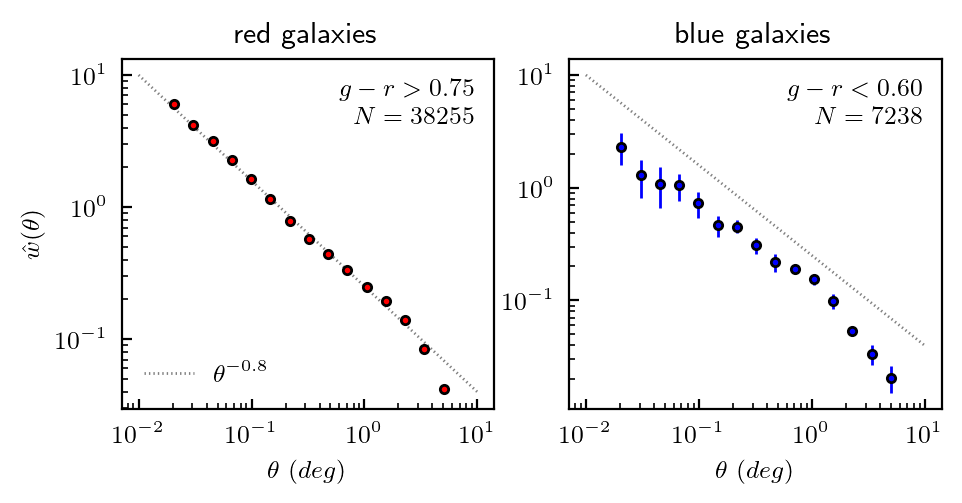

In [12]:
# Plot the results

plot_pretty(dpi=200)
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$g-r > 0.75$\n$N=%i$' % len(data_red),
          '$g-r < 0.60$\n$N=%i$' % len(data_blue)]

fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

for i in range(2):
    ax = fig.add_subplot(121 + i, xscale='log', yscale='log')

    col = 'blue'
    if i == 0: col = 'red'
    ax.errorbar(bin_centers, corr[i], corr_err[i],
                fmt='.k', color=col, markerfacecolor=col, ecolor=col, lw=1)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':', c='gray', linewidth=1, label=r'$\theta^{-0.8}$')

    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')
        ax.set_title('red galaxies')
        ax.legend(loc='lower left', frameon=False)
    else:
        ax.set_title('blue galaxies')

plt.show()

* What do we learn from the plots above?
* How would the correlation functions change if you change the magnitude cuts?

EXERCICE
* let's imagine that these galaxies live in dark matter halos with $\log(M_{halo}) \sim 12$
* what is the virial radius of these dark matter halos?
* convert this to an angular size at the mean redshift of the sample
* discuss one halo / two halo term, and central-satellite pairs

In [9]:
# Your code goes here

### Survey limiting magnitude

Because of variations in seeing, and weather conditions, the depth of a survey can vary across the sky. Going from 0.8" seeing to 0.4" seeing can change the depth of a survey by 0.5 magnitudes!!

How does one compute clustering in the presence of such effects?

The (usual) conservative approach is to only compute clustering for samples that are bright enough to not be affected by such effects.

However, let's briefly scroll through these two papers which describe methods to push towards the limiting mangitudes of surveys: 

* <a href="https://arxiv.org/abs/1507.08336">Suchyta et al. 2016</a>

*  <a href="http://adsabs.harvard.edu/abs/2015arXiv150900870R">Rykoff et al. 2015</a>


## The Limber Equation

Can we relate $w(\theta)$ to the real space correlation function? Yes, we can write down the exact relationship, but it is complcated (involoves many integrals), but via some approximations, these integrals can be simplified to form the __Liber Equation__ which can be used to compute $\xi$ from $w(\theta)$.

The exact equation is given by Equation 11 in  <a href="https://arxiv.org/pdf/astro-ph/0609165.pdf"> this paper by P. Simon.</a>

This paper also goes into detail about the approximations involved in the Limber equation.

<img width=800 align=left src="slidesfigs/astro610_lecture12-29.png"></img>

Take a quick look at the original paper by <a href="http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1954ApJ...119..655L&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf">Limber et al. 1994</a> .....

* Commissioned in 1959, the Shane telescope was named in honor of C. Donald Shane, Lick Observatory Director during its design and construction. For many years it was the second-largest reflector in the world.

However, note that one can circumvent the issue described above when using photo-z's. Althoght photo-zs are not precise enough to compute $\xi(s)$, they can be used to select complete samples and to compute $w(\theta)$ as a function of galaxy mass for example.

An example of such a computation, using high quality COSMOS photo-s'z is given in <a href="http://adsabs.harvard.edu/abs/2012ApJ...744..159L">Leauthaud et al. 2012</a> and  <a href="http://adsabs.harvard.edu/abs/2013ApJ...778...93T">Tinker et al. 2013</a>.

A note and comment by Alexie: Frank's statement that angular clustering has gone out of vogue, is also a reflection of the large role that the SDSS survey has played in extragalactic astronomy in the past decade. Because SDSS has spectra, it is much more useful to compute the projected correlation function rather than $w(\theta)$. However, new data sets on the horizon are mainly photometric (HSC, DES, LSST) and there is *no hope* of following up all of the galaxies in these surveys with spectroscopy. In parallel to this, the community has put a large effort into imporoving our understanding of how to compute photometric redshifts. Putting these two things together, I predict that we will see a lot more use of simple angular clustering in the coming years. Combined together with N-body simulations are increasing size and realisms, *forward modeling* signals such as $w(\theta)$ will also become more and more popular. In this approach, one uses an N-body simulation to directly model the data, varying some parameters related to galaxy formation to fit the data. __Semi empirical models of galaxy formation__ are particularily usesful in this regard. These will be covered in the third part of this class.

## Fingers of God

### The SDSS "Great Wall"

Let's examine the largest structure found in the distribution of SDSS galaxies - the so-called "SDSS Great Wall."  Below is a code to read SDSS spectroscopic sample with UPenn photometry, apply SDSS Great Wall region selection (approximately following <a href="http://adsabs.harvard.edu/abs/2008ApJ...674L..13C">Cowan and Ivezic (2008)</a>) and compute some basic galaxy properties, which you have seen 

In [10]:
from classcode.read_sdss_fits import read_sdss_fits
from classcode.setupdir import data_home_dir

from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('WMAP9')

# read fits file with the SDSS DR8 main spectroscopic sample
# The SDSS data file should be under your data directory
sdata = read_sdss_fits(data_home_dir()+'/SDSSspecgalsDR8full.fits')

# luminosity distance in Mpc
d_Lm = cosmo.luminosityDistance(sdata['z'])/cosmo.h

# apply cuts in RA, DEC, and z to select bright galaxies 
# in the region of the sky, where the Great Wall is located
isel = ((sdata['dec'] > -7) & (sdata['dec'] < 7) & 
        (sdata['ra'] > 80) & (sdata['ra'] < 280) & 
        (sdata['z'] > 0.01) & (sdata['z'] < 0.14))

gwdata = adata[isel]

# compute "comoving" distance for plotting spatial coordinates 
# (see Appendix A.1-A.3 for the difference between comoving and Luminosity distance)
d_C = d_Lm[isel]/(1. + gwdata['z'])

# construct 2D coordinates using RAs and d_C
# we are collapsing galaxies with different DECs onto 2D plane
# because the selected slice in DEC is only 14 degrees - pretty narrow 
Y = d_C * np.cos(gwdata['ra'] * np.pi / 180.) 
X = d_C * np.sin(gwdata['ra'] * np.pi / 180.)

fig = plt.figure(figsize=(8, 4))

# plot distribution of galaxies in the slice around the SDSS Great Wall
ax = plt.subplot(111, aspect='equal')
ax.scatter(X, Y, s=1, lw=0, c='k')

ax.set_xlim(-400, 300)
ax.set_ylim(-400, -150)

ax.set_xlabel(r'$y\ (\rm Mpc)$')
ax.set_ylabel(r'$x\ (\rm Mpc)$')

plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 63633 but corresponding boolean dimension is 673234

*Discussion*: what do you notice about this figure?

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

### Difference between real space and redshift space

The redshifts that we measure arise from a combination of cosmological redshifts and from peculiar velocities. The peculiar velocities cause overdensities to appear elongated along the line-of-light - these are called the __fingers of god__. 

Finger-of-god effects are one reason the 2D redshift space correlation function is not symmetrical (in real space, the correlation function is symmetrical). The other effects are the __Alcock Paczynski effect__, and __Kaier infall__, and will be discussed later.

Together, effects that change the 2D correlation function between real space to redshift space are known as __redshift space distortions__.

Because redshift space distortions are difficult to measure, it is common to use a different statistic which is insensitive to these redshift space distortions.

This statistic is the __projected correlation function__ written as $w_p(r_p)$


<img width=800 align=left src="slidesfigs/astro610_lecture12-37.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-38.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-45.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-46.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-47.png"></img>

## Baryon Acoustic Oscillations

At $z>1000$ baryons and photons are tighly coupled and are subject to radiation pressure (also called the "tight-coupling era").

The acoustic oscillation in this early plasma have left an imprint on the correlation function of galaxies, this BAO feature can be used as a __standard ruler__ to measure the expansion history of the universe.

Note: at late times, nonlinear structure formation broaden the acoustic peak, this degrades the measurement of the acoustic scale.

However, importantly, while non linearities broaden the peak, they do not appreciably shift the location of the pak. The former simply means that our measurement will be noisier, but a shift in the peak would introduce a bias. <a href="http://iopscience.iop.org/article/10.1086/518755/pdf">Eisenstein et al. 2007</a> argue that non linear formation does not shift the scale of the peak. Basically, the scale of the peak is 150 Mpc, but non linearities only move galaxies pairs within the peak by $\sim 10$ Mpc => broadens the peak.

FURTHER READING:
    
Read <a href="https://arxiv.org/abs/1607.03155">The clustering of galaxies in the completed SDSS-III Baryon Oscillation Spectroscopic Survey: cosmological analysis of the DR12 galaxy sample</a>. You can skip section 7

* What is $D_V(z)$?
* What is $f(z)$?
* What are $\alpha_{\bot}$ and $\alpha_{\|}$?
* Observe the BAO features in Figure 3
* What is the radial scale of the BAO feature?
* Look at the constraints in Figure 12 and Figure 15
    

## Redshift Space Distortions

<img width=800 align=left src="slidesfigs/astro610_lecture12-34.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-35.png"></img>

<img width=800 align=left src="slidesfigs/class_slides.001.png"></img>

<img width=800 align=left src="slidesfigs/class_slides.002.png"></img>

<img width=800 align=left src="slidesfigs/class_slides.003.png"></img>

<img width=800 align=left src="slidesfigs/class_slides.004.png"></img>

<img width=800 align=left src="slidesfigs/class_slides.005.png"></img>

## Modeling Redshift Space Distortions

<img width=800 align=left src="slidesfigs/astro610_lecture12-36.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-39.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-40.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-41.png"></img>

<img width=800 align=left src="slidesfigs/astro610_lecture12-42.png"></img>

### Further reading

*  <a href="http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1987MNRAS.227....1K&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf">Clustering in Real Space and Redshift Space by Nick Kaiser</a>

*  Will Percival's lectures on <a href="https://arxiv.org/abs/1312.5490">Large Scale Structure</a>


Next class: gravitational lensing ...